<a href="https://colab.research.google.com/github/nataliarigol/MathData24/blob/main/my_project_ncr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the Google Drive module from Google Colab to enable access to Google Drive files.
from google.colab import drive

# Mount Google Drive to the specified path, allowing the Colab environment to access and interact with files in your Drive.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define the path to the dataset directory in Google Drive.
# This directory contains the "clean vs. polluted rivers" data, which will be used for training and validation purposes.
data_dir = '/content/drive/My Drive/clean vs. polluted rivers/'

In [3]:
# Define the labels for the dataset, indicating the two classes: "clean" and "polluted".
# These labels will be used to differentiate between clean river images and polluted river images.
dataset_labels = ["clean", "polluted"]

In [4]:
# Import the transforms module from torchvision to apply various image preprocessing techniques.
from torchvision import transforms

# Define the mean and standard deviation for normalizing the dataset.
# These values are typically used for pretrained models like AlexNet or ResNet.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the data transformations for training and validation datasets.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crop the image to 224x224 pixels for data augmentation.
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally to increase dataset diversity.
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor and normalize pixel values to [0, 1].
        transforms.Normalize(mean, std)  # Normalize the image using the defined mean and standard deviation.
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256 pixels on the shorter side to standardize input size.
        transforms.CenterCrop(224),  # Crop the central part of the image to 224x224 pixels for consistent input.
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor and normalize pixel values to [0, 1].
        transforms.Normalize(mean, std)  # Normalize the image using the defined mean and standard deviation.
    ]),
}

In [5]:
# Import the datasets module from torchvision to work with preloaded image datasets.
from torchvision import datasets
# Import PyTorch for creating data loaders and handling tensor operations.
import torch
# Import the os module for interacting with the file system.
import os

# Define a function to create data loaders for training and validation datasets.
# This function helps load images in batches for model training and evaluation.
def create_dataloaders(data_dir, batch_size=16):
    # Create image datasets for training and validation using ImageFolder, applying the corresponding data transformations.
    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_dir, x),  # Construct the path to the dataset folder ('train' or 'valid').
            data_transforms[x]  # Apply data transformations defined earlier for training or validation.
        ) for x in ['train', 'valid']
    }

    # Create data loaders for training and validation datasets, which load the images in batches.
    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x],  # Load images from the respective dataset.
            batch_size=batch_size,  # Specify the number of images to load per batch.
            shuffle=True,  # Shuffle the data to improve training performance.
            num_workers=2  # Set the number of subprocesses used for data loading to speed up the process.
        ) for x in ['train', 'valid']
    }

    # Get the sizes of the training and validation datasets.
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
    # Get the class names (labels) from the training dataset.
    class_names = image_datasets['train'].classes

    # Return the data loaders, dataset sizes, and class names for further use in model training.
    return dataloaders, dataset_sizes, class_names

# Create data loaders, get dataset sizes, and class names for training and validation datasets.
dataloaders, dataset_sizes, class_names = create_dataloaders(data_dir)

In [6]:
# Import the models module from torchvision to use pretrained models like AlexNet.
import torchvision.models as models
# Import the nn module from PyTorch to modify neural network layers.
import torch.nn as nn

# Load a pretrained AlexNet model, which will be fine-tuned for the current classification task.
model = models.alexnet(pretrained=True)

# Modify the last layer of the classifier to match the number of classes in the current dataset.
# The original output layer has 4096 input features and is replaced with a new layer with the number of classes.
model.classifier[6] = nn.Linear(4096, len(class_names))

# Set the model to use GPU if available, otherwise default to CPU.
# This helps in speeding up the training process when a CUDA-compatible GPU is available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Transfer the model to the appropriate device (GPU or CPU).
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 129MB/s]


In [7]:
# Import the optim module from PyTorch to use optimization algorithms for training the model.
import torch.optim as optim
# Import the learning rate scheduler module from PyTorch to adjust the learning rate during training.
from torch.optim import lr_scheduler

# Define a function to train the model using the given data loaders and dataset sizes.
# This function performs training and validation over multiple epochs.
def train_model(model, dataloaders, dataset_sizes, num_epochs=3):
    # Define the loss function, which is cross-entropy loss suitable for multi-class classification.
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer, using Stochastic Gradient Descent (SGD) with a learning rate of 0.003 and momentum of 0.9.
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    # Set up a learning rate scheduler to decay the learning rate every 7 epochs by a factor of 0.1.
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Loop over the specified number of epochs to train and validate the model.
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')  # Print the current epoch number.
        print('-' * 10)  # Print a separator line for better readability.

        # Iterate over both training and validation phases.
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set the model to training mode to enable gradient updates.
            else:
                model.eval()  # Set the model to evaluation mode to disable gradient updates.

            running_corrects = 0  # Initialize the count of correct predictions.

            # Iterate over the data batches in the current phase.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  # Move the input images to the appropriate device (GPU or CPU).
                labels = labels.to(device)  # Move the labels to the appropriate device.

                optimizer.zero_grad()  # Zero the parameter gradients to prevent accumulation from previous steps.

                # Enable gradient calculation only during the training phase.
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # Perform a forward pass through the model.
                    _, preds = torch.max(outputs, 1)  # Get the predicted class with the highest score.
                    loss = criterion(outputs, labels)  # Calculate the loss between predicted and actual labels.

                    if phase == 'train':
                        loss.backward()  # Compute the gradients during the training phase.
                        optimizer.step()  # Update the model parameters based on the gradients.

                # Update the count of correct predictions.
                running_corrects += torch.sum(preds == labels.data)

            # Calculate the accuracy for the current epoch and phase.
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase.capitalize()} Acc: {epoch_acc:.4f}')  # Print the accuracy for the current phase.

            if phase == 'train':
                scheduler.step()  # Update the learning rate according to the scheduler.

        print()  # Print an empty line for better readability between epochs.

    # Return the trained model.
    return model

# Train the model using the defined function, data loaders, and dataset sizes.
model = train_model(model, dataloaders, dataset_sizes)

Epoch 1/3
----------
Train Acc: 0.7051
Valid Acc: 1.0000

Epoch 2/3
----------
Train Acc: 0.9231
Valid Acc: 0.9000

Epoch 3/3
----------
Train Acc: 0.7564
Valid Acc: 0.8500



In [8]:
# Save the trained model's state dictionary to a file named 'clean_polluted_river_model.pth'.
# The state dictionary contains the model parameters, which can be loaded later to reuse the trained model.
torch.save(model.state_dict(), 'clean_polluted_river_model.pth')

In [9]:
# Load the model parameters from the saved state dictionary file 'clean_polluted_river_model.pth'.
# This allows the model to be restored to the same state it was in after training.
model.load_state_dict(torch.load('clean_polluted_river_model.pth'))

# Set the model to evaluation mode. This is crucial for disabling certain layers like dropout and batch normalization
# that behave differently during training, ensuring consistent results during inference.
model.eval()

<ipython-input-9-fc44ca8d67ae>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('clean_polluted_river_model.pth'))


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

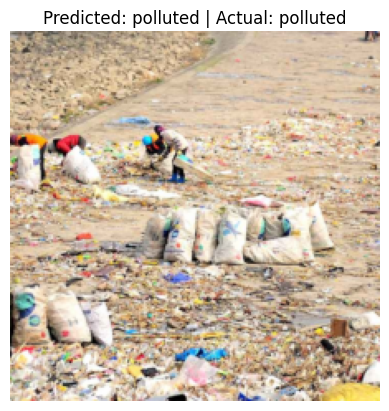

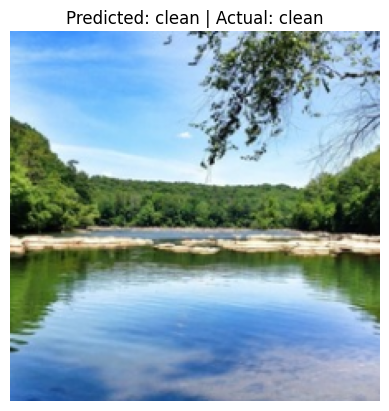

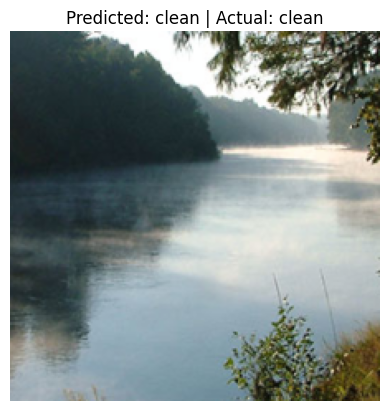

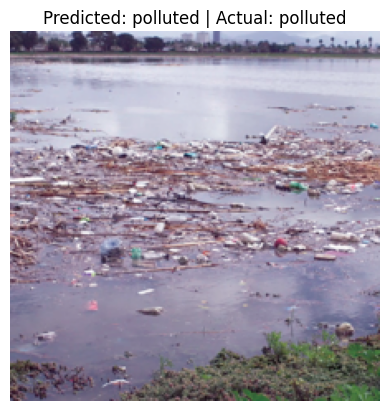

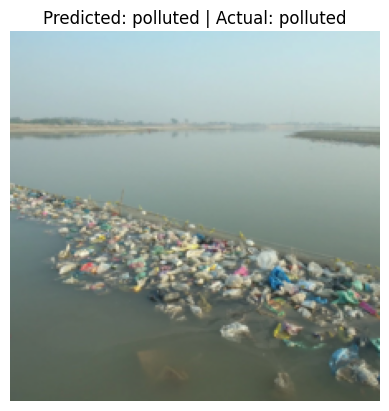

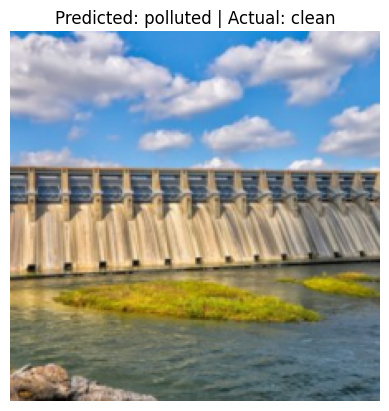

In [10]:
# Import the numpy library for numerical operations, especially for handling arrays.
import numpy as np
# Import the matplotlib.pyplot module to display images.
import matplotlib.pyplot as plt

# Define a function to display an image.
# This function converts the input tensor to a NumPy array and denormalizes it before displaying the image.
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))  # Move the tensor to CPU, convert to a NumPy array, and transpose dimensions to (H, W, C).
    inp = std * inp + mean  # Denormalize the image using the previously defined mean and standard deviation.
    inp = np.clip(inp, 0, 1)  # Clip values to be between 0 and 1 to ensure valid image pixel values.
    plt.imshow(inp)  # Display the image using matplotlib.
    if title:
        plt.title(title)  # Set the title if provided.
    plt.axis('off')  # Hide the axis for better visualization.
    plt.show()  # Display the image.

# Define a function to visualize model predictions for a few validation images.
# This function runs the model in evaluation mode and displays images along with predicted and actual labels.
def visualize_model(model, dataloaders, num_images=6):
    model.eval()  # Set the model to evaluation mode.
    images_so_far = 0  # Initialize the count of images displayed so far.

    with torch.no_grad():  # Disable gradient calculation for faster inference and reduced memory usage.
        # Iterate over the validation data loader to get batches of images and labels.
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)  # Move the input images to the appropriate device (GPU or CPU).
            labels = labels.to(device)  # Move the labels to the appropriate device.

            outputs = model(inputs)  # Perform a forward pass through the model.
            _, preds = torch.max(outputs, 1)  # Get the predicted class with the highest score for each input image.

            # Iterate over the images in the current batch.
            for j in range(inputs.size()[0]):
                images_so_far += 1  # Increment the count of images displayed.
                # Display the image with the predicted and actual labels.
                imshow(inputs.cpu().data[j], title=f'Predicted: {dataset_labels[preds[j]]} | Actual: {dataset_labels[labels[j]]}')
                if images_so_far == num_images:  # Stop when the specified number of images has been displayed.
                    return

# Call the visualize_model function to display a few validation images and their predicted labels.
visualize_model(model, dataloaders)

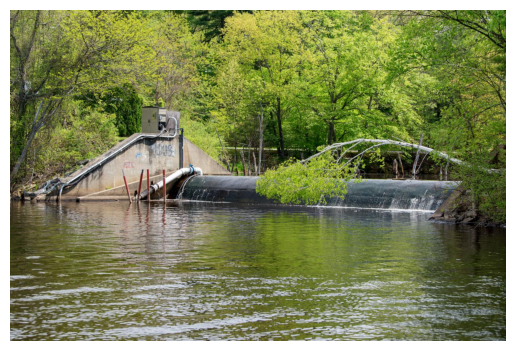

In [11]:
#TESTING
# Import the Image module from PIL (Pillow) to work with image files.
from PIL import Image
# Import matplotlib.pyplot to display the image.
import matplotlib.pyplot as plt

# Define the path to the image file stored in Google Drive.
# Update the path if your image is located in a different directory.
image_path = '/content/drive/My Drive/aaaaaaaaaa.jpg'

# Open the image file using PIL and store it in the variable 'image'.
image = Image.open(image_path)

# Display the opened image using matplotlib.
plt.imshow(image)  # Show the image.
plt.axis('off')  # Hide the axis for better visualization.
plt.show()  # Display the image on screen.

In [12]:
# Import the transforms module from torchvision to apply transformations to the input image.
from torchvision import transforms
# Import torch for tensor operations and model inference.
import torch

# Define the transformations to apply to the image for model compatibility.
# This includes resizing, cropping, converting to a tensor, and normalizing.
test_transforms = transforms.Compose([
    transforms.Resize(256),  # Resize the shorter side of the image to 256 pixels.
    transforms.CenterCrop(224),  # Crop the central region of the image to 224x224 pixels.
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor with values in [0, 1].
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using mean and standard deviation.
])

# Apply the defined transformations to the image and add a batch dimension.
# The batch dimension is needed since the model expects a batch of images as input.
image_tensor = test_transforms(image).unsqueeze(0).to(device)

# Set the model to evaluation mode to prepare for inference.
model.eval()

# Make predictions on the input image.
with torch.no_grad():  # Disable gradient calculation to speed up inference and reduce memory usage.
    outputs = model(image_tensor)  # Get the model outputs for the input image.
    _, preds = torch.max(outputs, 1)  # Get the predicted class with the highest score.

# Print the predicted label for the image.
print(f'Predicted: {dataset_labels[preds[0]]}')

Predicted: clean


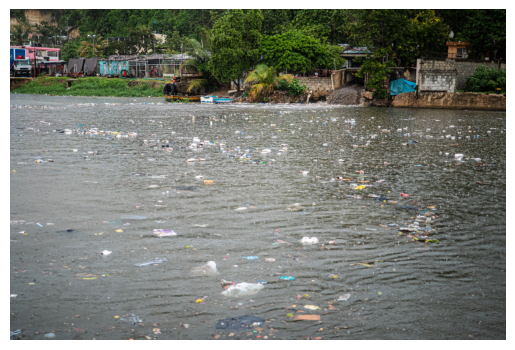

In [13]:
# Define the path to the image file stored in Google Drive.
# Update the path if your image is located in a different directory.
image_path = '/content/drive/My Drive/bbbbbbb.jpg'

# Open the image file using PIL (Pillow) and store it in the variable 'image'.
image = Image.open(image_path)

# Display the opened image using matplotlib.
plt.imshow(image)  # Show the image.
plt.axis('off')  # Hide the axis for a cleaner display without the coordinate values.
plt.show()  # Display the image on screen.

In [14]:
# Define the transformations to apply to the image for compatibility with the model input requirements.
# This includes resizing, cropping, converting to a tensor, and normalizing.
test_transforms = transforms.Compose([
    transforms.Resize(256),  # Resize the shorter side of the image to 256 pixels.
    transforms.CenterCrop(224),  # Crop the center of the image to 224x224 pixels.
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor with values scaled between [0, 1].
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image using predefined mean and std values.
])

# Apply the defined transformations to the input image and add a batch dimension.
# Adding a batch dimension is necessary because the model expects inputs in batches.
image_tensor = test_transforms(image).unsqueeze(0).to(device)

# Set the model to evaluation mode to ensure layers like dropout and batch normalization behave appropriately for inference.
model.eval()

# Perform inference on the image to make predictions.
with torch.no_grad():  # Disable gradient calculations to speed up inference and reduce memory consumption.
    outputs = model(image_tensor)  # Get the output scores from the model for each class.
    _, preds = torch.max(outputs, 1)  # Identify the predicted class with the highest score.

# Print the predicted class label for the image.
print(f'Predicted: {dataset_labels[preds[0]]}')

Predicted: polluted
